In [3]:
# Regular Imports
%matplotlib inline
import matplotlib.image as mpimg
from tabulate import tabulate
import missingno as msno 
from IPython.display import display_html
from PIL import Image
import gc
import cv2
from scipy.stats import pearsonr
from skimage.transform import resize
import copy

# Segmentation
from glob import glob
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy.ndimage
from skimage.transform import resize
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.tools import FigureFactory as FF
from plotly.graph_objs import *
init_notebook_mode(connected=True) 

import warnings
warnings.filterwarnings("ignore")

In [20]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [21]:
# Import train + test data
train = pd.read_csv("../input/osic-pulmonary-fibrosis-progression/train.csv")
test = pd.read_csv("../input/osic-pulmonary-fibrosis-progression/test.csv")

# Train len
print("Total Recordings in Train Data: {:,}".format(len(train)))

Total Recordings in Train Data: 1,549


In [22]:
# Create base director for Train .dcm files
director = "../input/osic-pulmonary-fibrosis-progression/train"

# Create path column with the path to each patient's CT
train["Path"] = director + "/" + train["Patient"]

# Create variable that shows how many CT scans each patient has
train["CT_number"] = 0

for k, path in enumerate(train["Path"]):
    train["CT_number"][k] = len(os.listdir(path))

# Lung Masks - Part of Image Pre-processing

1. Purpose of masking: Is a part of image pre-processing, helps to identify boundaries surrounding the volume of interest (in this case lung boundary)

2. Drawbacks: sometimes could lead to exclusion of certain important features like lesions

In [3]:
from sklearn.cluster import KMeans
from skimage import morphology, measure

def mask_lung(img, display=False):
    row_size = img.shape[0]
    col_size = img.shape[1]
    
    img_mean = np.mean(img)
    img_std = np.std(img)
    img_max = np.max(img)
    img_min = np.min(img)
    
    # normalize image
    img = img-img_mean
    img = img/img_std
    
    # finding the average pixel value in the middle of the lung to compensate the distorted boundaries (max and min)
    middle = img[int(col_size/5):int(col_size/5*4) , int(row_size/5):int(row_size/5*4)]
    img_middle_mean = np.mean(middle)
    img[img==img_max] = img_middle_mean
    img[img==img_min] = img_middle_mean
    
    # separating the front (bone and other tissue) and the back (lung and air) of the image using KMeans
    kmeans = KMeans(n_clusters=2).fit(np.reshape(middle, [np.prod(middle.shape), 1]))
    centers = sorted(kmeans.cluster_centers_.flatten())
    threshold = np.mean(centers)
    thresh_img = np.where(img<threshold, 1.0, 0.0)
    ## Mask1: thresh_img is the image with lung+air
    
    # Making the thresh_img finer by eroding away the finer elements of the image
    # Then dialating those eroded finer elements 
    eroded = morphology.erosion(thresh_img, np.ones([3,3]))
    dilation = morphology.dilation(eroded, np.ones([8,8]))
    ## Mask 2: dialation
    
    # Getting different labels in different colours
    labels = measure.label(dilation)
    ## Mask 3: labels
    
    # Identifying regions of these different labels
    regions = measure.regionprops(labels)
    good_labels=[]
    
    
    for prop in regions:
        B = prop.bbox
        if B[2]-B[0]<row_size/10*9 and B[3]-B[1]<col_size/10*9 and B[0]>row_size/5 and B[2]<col_size/5*4:
            good_labels.append(prop.label)
    
    
    # Final mask using only the good labels
    
    # empty mask
    mask = np.ndarray([row_size, col_size], dtype=np.int8)
    mask[:] = 0
    
    # fill mask with good labels' dialation
    for N in good_labels:
        mask = mask + np.where(labels==N,1,0)
    
    mask = morphology.dilation(mask, np.ones([10,10]))
    
    
    if (display):
        fig, ax = plt.subplots(3,2, figsize=[12,12])
        
        ax[0,0].set_title("Original image")
        ax[0,0].imshow(img, cmap='gray')
        ax[0,0].axis('off')
        
        ax[0,1].set_title("Threshold - Separating the lung")
        ax[0,1].imshow(thresh_img, cmap='gray')
        ax[0,1].axis('off')
        
        ax[1,0].set_title("After Erosion and Dilation")
        ax[1,0].imshow(dilation, cmap='gray')
        ax[1,0].axis('off')
        
        ax[1,1].set_title("Different Color Labels")
        ax[1,1].imshow(labels)
        ax[1,1].axis('off')
        
        ax[2,0].set_title("Final Mask")
        ax[2,0].imshow(mask, cmap='gray')
        ax[2,0].axis('off')
        
        ax[2,1].set_title("Applying Mask on original Image")
        ax[2,1].imshow(mask*img, cmap='gray')
        ax[2,1].axis('off')
        
        plt.show()
    
    mask_on_img = mask*img
    
    return mask_on_img

### Mask one image

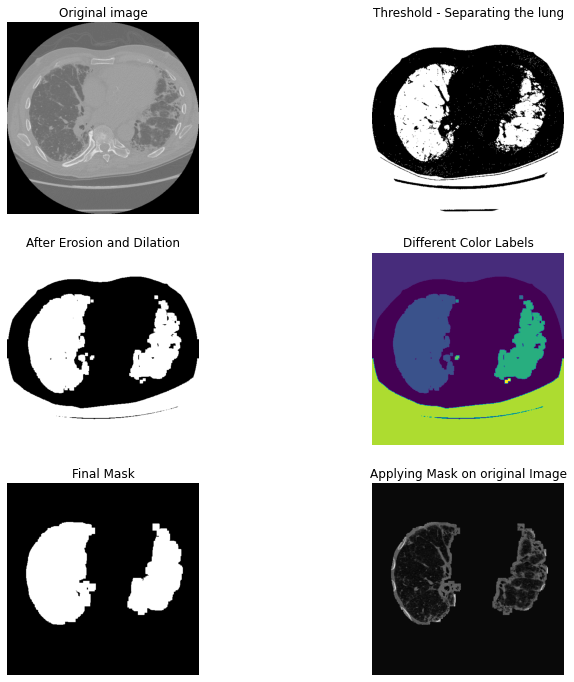

In [4]:
import pydicom

path = "../input/osic-pulmonary-fibrosis-progression/train/ID00007637202177411956430/19.dcm"
dataset = pydicom.dcmread(path)
img = dataset.pixel_array

maskedImg = mask_lung(img, display=True)

### Mask Images for one Patient

Lungs are quite visible, but on images at the beginning and towards the end the lung dissapears completely.

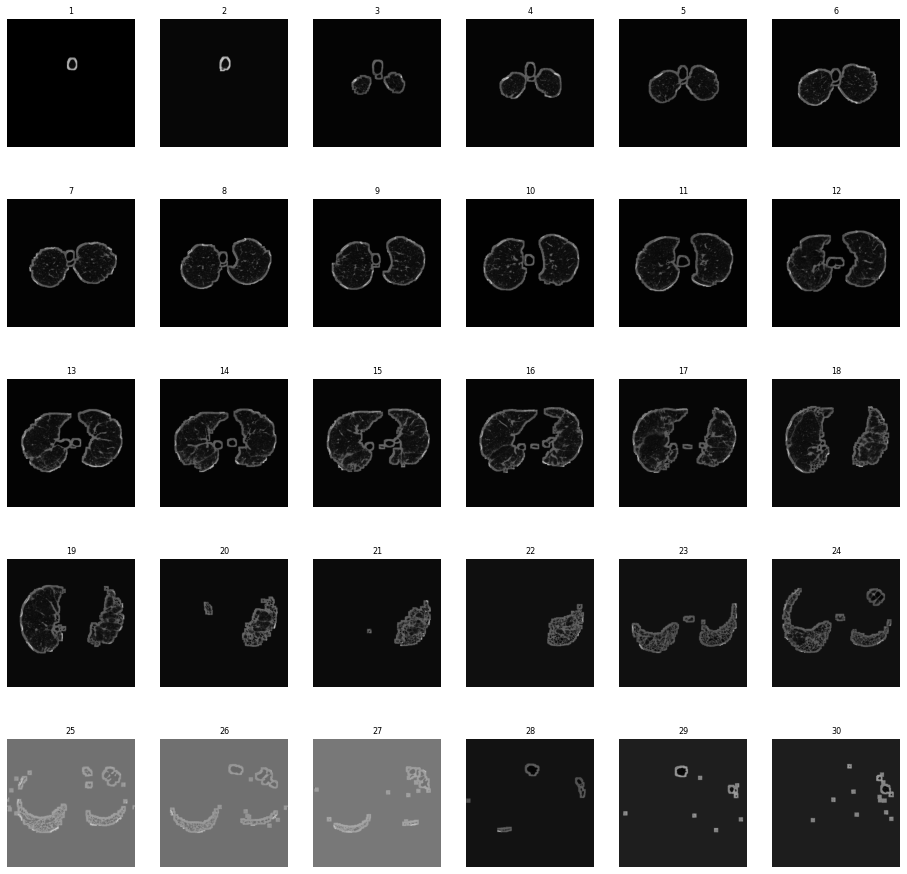

In [7]:
import re

# select any patient
patient_dir = "../input/osic-pulmonary-fibrosis-progression/train/ID00007637202177411956430"

fig = plt.figure(figsize=(16,16))
columns = 6
rows = 5

for i in range(1, columns*rows+1):
    image_path = patient_dir + '/' + str(i) + '.dcm'
    ds = pydicom.dcmread(image_path)
    image = ds.pixel_array
    masked_image = mask_lung(image)
    
    fig.add_subplot(rows, columns, i)
    plt.imshow(masked_image, cmap='gray')
    plt.title(i, fontsize=8)
    plt.axis('off')

# Extracting the metadata from DICOM files

In [5]:
import sys
!cp ../input/rapids/rapids.0.17.0 /opt/conda/envs/rapids.tar.gz
!cd /opt/conda/envs/ && tar -xzvf rapids.tar.gz > /dev/null
sys.path = ["/opt/conda/envs/rapids/lib/python3.7/site-packages"] + sys.path
sys.path = ["/opt/conda/envs/rapids/lib/python3.7"] + sys.path
sys.path = ["/opt/conda/envs/rapids/lib"] + sys.path 
!cp /opt/conda/envs/rapids/lib/libxgboost.so /opt/conda/lib/

In [8]:
!pip install --upgrade pip

     |████████████████████████████████| 1.5 MB 2.9 MB/s eta 0:00:01
  Attempting uninstall: pip
    Found existing installation: pip 20.1.1
    Uninstalling pip-20.1.1:
      Successfully uninstalled pip-20.1.1


In [10]:
conda install -c nvidia -c rapidsai -c numba -c conda-forge -c defaults cudf

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: - ^C
failed with repodata from current_repodata.json, will retry with next repodata source.

CondaError: KeyboardInterrupt


Note: you may need to restart the kernel to use updated packages.


In [11]:
## cudf is pandas for GPU -- s a Python GPU DataFrame library 
## built on the Apache Arrow columnar memory format
## for loading, joining, aggregating, filtering, and otherwise manipulating data all in a pandas-like API
import tqdm

In [16]:
# using .get() function for .dcm files
import pydicom

def get_observation_data(path):
    
    image_data = pydicom.read_file(path)
    
    # Dictionary to store the information from the image
    obs_data = {
        "FileNumber": path.split("/")[5],
        "Rows": image_data.get("Rows"),
        "Columns": image_data.get("Columns"),
        "PatientID": image_data.get("PatientID"),
        "BodyPartExamined": image_data.get("BodyPartExamined"),
        "RotationDirection": image_data.get("RotationDirection"),
        "ConvolutionKernel": image_data.get("convolutionKernel"),
        "PatientPosition": image_data.get("PatientPosition"),
        "PhotometricInterpretation": image_data.get("PhotometricInterpretation"),
        "Modality": image_data.get("Modality"),
        "StudyInstanceUID": image_data.get("StudyInstanceUID"),
        "PixelPaddingvalue": image_data.get("PixelPaddingValue"),
        "BitsAllocated": image_data.get("BitsAllocated"),
        "BitsStored": image_data.get("BitsStored"),
        "PixelRepresentation": image_data.get("PixelRepresentation"),
        "RescaleType": image_data.get("RescaleType")
    }
        

    # Adding some int fields in observation data dictionary
    # Column names
    int_cols = ['SliceThickness', 'KVP', 'DistanceSourceToDetector',
           'DistanceSourceToPatient', 'GantryDetectorTilt', 
           'TableHeight', 'XRayTubeCurrent', 'GeneratorPower',
           'WindowCenter', 'WindowWidth', 'SliceLocation',
           'RescaleIntercept', 'RescaleSlope']


    for k in int_cols:
        obs_data[k] = int(image_data.get(k)) if k in image_data else None
    
    
    # Adding some string fields in observation data dictionary
    str_cols = ['ImagepositionPatient', 'ImageOrientationPatient', 
                    'ImageType', 'PixelSpacing']
    
    for k in str_cols:
        obs_data[k] = str(image_data.get(k)) if k in image_data else None
    
    
    return obs_data

    
    

In [27]:
p = "../input/osic-pulmonary-fibrosis-progression/train/ID00007637202177411956430/10.dcm"
get_observation_data(p)

{'FileNumber': '10.dcm',
 'Rows': 512,
 'Columns': 512,
 'PatientID': 'ID00007637202177411956430',
 'BodyPartExamined': 'Chest',
 'RotationDirection': 'CW',
 'ConvolutionKernel': None,
 'PatientPosition': 'FFS',
 'PhotometricInterpretation': 'MONOCHROME2',
 'Modality': 'CT',
 'StudyInstanceUID': '2.25.80896671862726099888461805953012988790',
 'PixelPaddingvalue': -2000,
 'BitsAllocated': 16,
 'BitsStored': 16,
 'PixelRepresentation': 1,
 'RescaleType': 'HU',
 'SliceThickness': 1,
 'KVP': 120,
 'DistanceSourceToDetector': 949,
 'DistanceSourceToPatient': 541,
 'GantryDetectorTilt': 0,
 'TableHeight': 130,
 'XRayTubeCurrent': 79,
 'GeneratorPower': 9600,
 'WindowCenter': -500,
 'WindowWidth': -1500,
 'SliceLocation': -159,
 'RescaleIntercept': -1024,
 'RescaleSlope': 1,
 'ImagepositionPatient': None,
 'ImageOrientationPatient': '[1.000000, 0.000000, 0.000000, 0.000000, 1.000000, 0.000000]',
 'ImageType': "['ORIGINAL', 'PRIMARY', 'AXIAL']",
 'PixelSpacing': '[0.652344, 0.652344]'}

In [23]:
# Getting paths for all images

paths = []

for path in train["Path"]:
    for doc in os.listdir(path):
        paths.append(path+"/"+doc)


In [24]:
for i in range(1,5):
    print(paths[i])

../input/osic-pulmonary-fibrosis-progression/train/ID00007637202177411956430/18.dcm
../input/osic-pulmonary-fibrosis-progression/train/ID00007637202177411956430/9.dcm
../input/osic-pulmonary-fibrosis-progression/train/ID00007637202177411956430/22.dcm
../input/osic-pulmonary-fibrosis-progression/train/ID00007637202177411956430/25.dcm


In [28]:
## Dump the dictionary in a dataframe
exceptions = 0
dicts = []

for path in tqdm.tqdm(paths):
    try:
        d = get_observation_data(path)
        dicts.append(d)
    except Exception as e:
        exceptions += 1
        continue

100%|██████████| 289826/289826 [18:05<00:00, 267.10it/s] 


In [30]:
example = get_observation_data(p)

In [31]:
meta_train_data = pd.DataFrame(data = dicts, columns = example.keys())

In [32]:
meta_train_data.head()

,FileNumber,Rows,Columns,PatientID,BodyPartExamined,RotationDirection,ConvolutionKernel,PatientPosition,PhotometricInterpretation,Modality,...,GeneratorPower,WindowCenter,WindowWidth,SliceLocation,RescaleIntercept,RescaleSlope,ImagepositionPatient,ImageOrientationPatient,ImageType,PixelSpacing
0,12.dcm,512,512,ID00007637202177411956430,Chest,CW,None,FFS,MONOCHROME2,CT,...,9600.0,-500,-1500,-179.0,-1024,1,None,"[1.000000, 0.000000, 0.000000, 0.000000, 1.000...","['ORIGINAL', 'PRIMARY', 'AXIAL']","[0.652344, 0.652344]"
1,18.dcm,512,512,ID00007637202177411956430,Chest,CW,None,FFS,MONOCHROME2,CT,...,9600.0,-500,-1500,-239.0,-1024,1,None,"[1.000000, 0.000000, 0.000000, 0.000000, 1.000...","['ORIGINAL', 'PRIMARY', 'AXIAL']","[0.652344, 0.652344]"
2,9.dcm,512,512,ID00007637202177411956430,Chest,CW,None,FFS,MONOCHROME2,CT,...,9600.0,-500,-1500,-149.0,-1024,1,None,"[1.000000, 0.000000, 0.000000, 0.000000, 1.000...","['ORIGINAL', 'PRIMARY', 'AXIAL']","[0.652344, 0.652344]"
3,22.dcm,512,512,ID00007637202177411956430,Chest,CW,None,FFS,MONOCHROME2,CT,...,9600.0,-500,-1500,-279.0,-1024,1,None,"[1.000000, 0.000000, 0.000000, 0.000000, 1.000...","['ORIGINAL', 'PRIMARY', 'AXIAL']","[0.652344, 0.652344]"
4,25.dcm,512,512,ID00007637202177411956430,Chest,CW,None,FFS,MONOCHROME2,CT,...,9600.0,-500,-1500,-309.0,-1024,1,None,"[1.000000, 0.000000, 0.000000, 0.000000, 1.000...","['ORIGINAL', 'PRIMARY', 'AXIAL']","[0.652344, 0.652344]"
